In [1]:
import numpy as np
import pandas as pd
import os
from scipy import ndimage
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.ndimage import zoom
from soma import aims

In [2]:
def get_neighbors(skels, value):

    list_convolved_skels = []
    for skel in skels:
        skel_simple = (skel == value).astype(int)
        # Convolve over all three axes in a for loop
        k = np.array([[[1,1,1],
                    [1,1,1],
                    [1,1,1]],
                    [[1,1,1],
                    [1,1,1],
                    [1,1,1]],
                    [[1,1,1],
                    [1,1,1],
                    [1,1,1]]])
        convolved_skel = ndimage.convolve(skel_simple, k, mode='constant', cval=0.0)
        convolved_skel = skel_simple * convolved_skel
        list_convolved_skels.append(convolved_skel)
    
    return list_convolved_skels


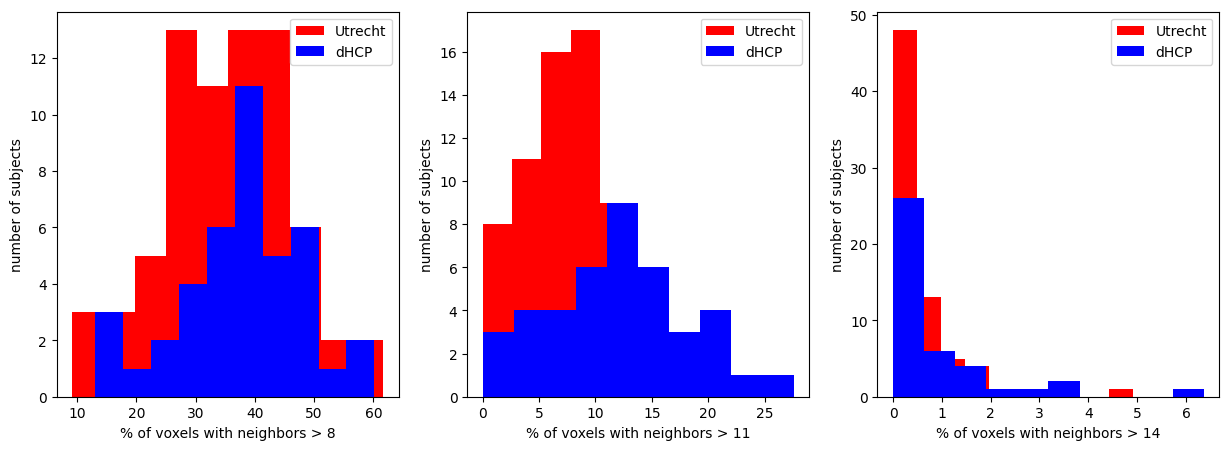

In [3]:
# Utrecht and dHCP

dir_skels = '/neurospin/dico/data/deep_folding/current/datasets/utrecht_dHCP/crops/2mm/CINGULATE_40wks/mask/Rskeleton.npy'
thresholds = [9, 12, 15]
skels = np.load(dir_skels)
skels = skels[:,:,:,:,0]

list_convolved_skels = get_neighbors(skels, 60)

fig, axs = plt.subplots(ncols=len(thresholds), figsize=(5*len(thresholds), 5))

for idx, threshold in enumerate(thresholds):

    proportion_wrong_thickness = []
    for im in list_convolved_skels:
        proportion_wrong_thickness.append(100 * np.sum(im > threshold) / np.sum(im > 0))

    axs[idx].hist(proportion_wrong_thickness[:71], color='r', label='Utrecht')
    axs[idx].hist(proportion_wrong_thickness[71:], color='b', label='dHCP')
    axs[idx].set_xlabel(f'% of voxels with neighbors > {threshold-1}')
    axs[idx].set_ylabel('number of subjects')
    axs[idx].legend()
plt.show()

In [9]:
# in Utrecht / dHCP, use the threshold to create a classifier and measure AUC

dir_skels = '/neurospin/dico/data/deep_folding/current/datasets/utrecht_dHCP/crops/2mm/CINGULATE_40wks/mask/Rskeleton.npy'

skels = np.load(dir_skels)
skels = skels[:,:,:,:,0]
list_convolved_skels = get_neighbors(skels, 60)
labels = [0 for k in range(71)] + [1 for k in range(41)]

for threshold in range(1, 18):

    proportion_wrong_thickness = []
    for im in list_convolved_skels:
        proportion_wrong_thickness.append(100 * np.sum(im > threshold) / np.sum(im > 0))

    fpr, tpr, thresholds = metrics.roc_curve(labels, proportion_wrong_thickness, pos_label=1)
    AUC = metrics.auc(fpr, tpr)
    print(f'threshold {threshold}: {AUC}')

threshold 1: 0.3936791480590862
threshold 2: 0.45345242184816215
threshold 3: 0.4450360700790107
threshold 4: 0.5132256956372381
threshold 5: 0.5596015115080728
threshold 6: 0.5860529027825488
threshold 7: 0.612332531776022
threshold 8: 0.5781518378564067
threshold 9: 0.5810717966334593
threshold 10: 0.591377533493645
threshold 11: 0.6351769151494331
threshold 12: 0.6808656818962556
threshold 13: 0.6812092064582618
threshold 14: 0.6047749914118861
threshold 15: 0.599278598419787
threshold 16: 0.5745448299553418
threshold 17: 0.496221229817932


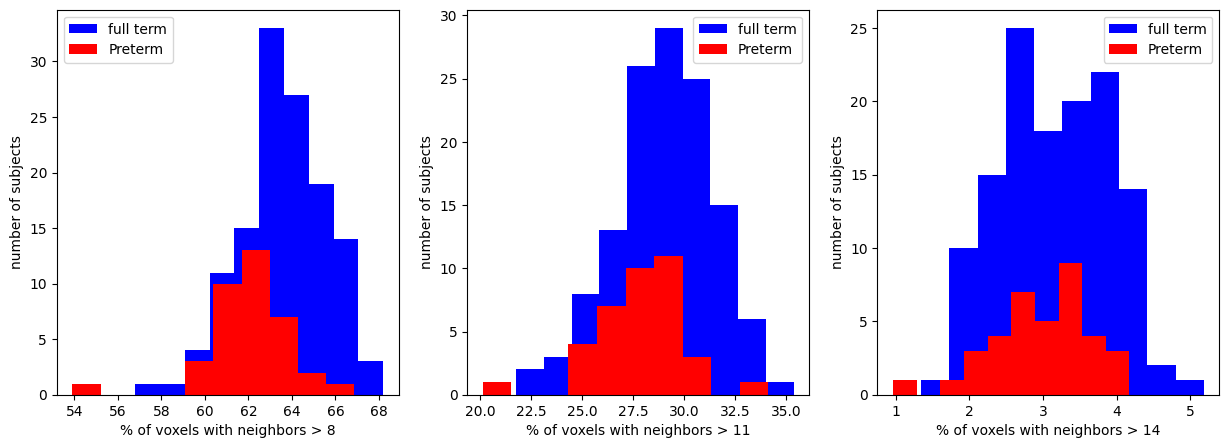

In [10]:
# new dHCP_165 data

dir_skels = '/neurospin/dico/jlaval/data/dHCP_165/skels.npy'
dir_names = '/neurospin/dico/jlaval/data/dHCP_165/names.npy'
labels_dir = '/neurospin/dico/jlaval/data/labels_dHCP.csv'
df_labels = pd.read_csv(labels_dir, sep=',')
thresholds = [9, 12, 15]
skels = np.load(dir_skels)
skels = skels[:,:,:,:,0]
names = np.load(dir_names)
labels = [df_labels.loc[df_labels['Subject']==name]['Preterm'].tolist()[0] for name in names]

list_convolved_skels = get_neighbors(skels, 60)

fig, axs = plt.subplots(ncols=len(thresholds), figsize=(5*len(thresholds), 5))

for idx, threshold in enumerate(thresholds):

    proportion_wrong_thickness = []
    for im in list_convolved_skels:
        proportion_wrong_thickness.append(100 * np.sum(im > threshold) / np.sum(im > 0))

    proportion_wrong_thickness_preterm = [elem for idx, elem in enumerate(proportion_wrong_thickness) if labels[idx]]
    proportion_wrong_thickness_full_term = [elem for idx, elem in enumerate(proportion_wrong_thickness) if not labels[idx]]

    axs[idx].hist(proportion_wrong_thickness_full_term, color='b', label='full term')
    axs[idx].hist(proportion_wrong_thickness_preterm, color='r', label='Preterm')
    axs[idx].set_xlabel(f'% of voxels with neighbors > {threshold-1}')
    axs[idx].set_ylabel('number of subjects')
    axs[idx].legend()
plt.show()

In [11]:
skels.shape

(165, 96, 114, 96)

In [12]:
# measure AUC depending on threshold

for threshold in range(1, 18):

    proportion_wrong_thickness = []
    for im in list_convolved_skels:
        proportion_wrong_thickness.append(100 * np.sum(im > threshold) / np.sum(im > 0))

    fpr, tpr, thresholds = metrics.roc_curve(labels, proportion_wrong_thickness, pos_label=0)
    AUC = metrics.auc(fpr, tpr)
    print(f'threshold {threshold}: {AUC}')

threshold 1: 0.5926942567567567
threshold 2: 0.6936233108108107
threshold 3: 0.7371199324324325
threshold 4: 0.7637246621621621
threshold 5: 0.766258445945946
threshold 6: 0.7772381756756757
threshold 7: 0.7552787162162161
threshold 8: 0.7288851351351351
threshold 9: 0.7276182432432433
threshold 10: 0.7181165540540542
threshold 11: 0.6769425675675675
threshold 12: 0.6395692567567568
threshold 13: 0.6131756756756758
threshold 14: 0.5785472972972973
threshold 15: 0.5679898648648648
threshold 16: 0.5553209459459458
threshold 17: 0.5900548986486487


A simple convolution followed by a sum of pixels over threshold gives an AUC of 0.64 again.. Threshold 1 simply reflects the differences in volume, whereas threshold > 9 are the effect of resampling (of course linked to volume, but in theory in an opposite way). The inversion of the AUC is observed in Utrecht / dHCP but not in dHCP_165.

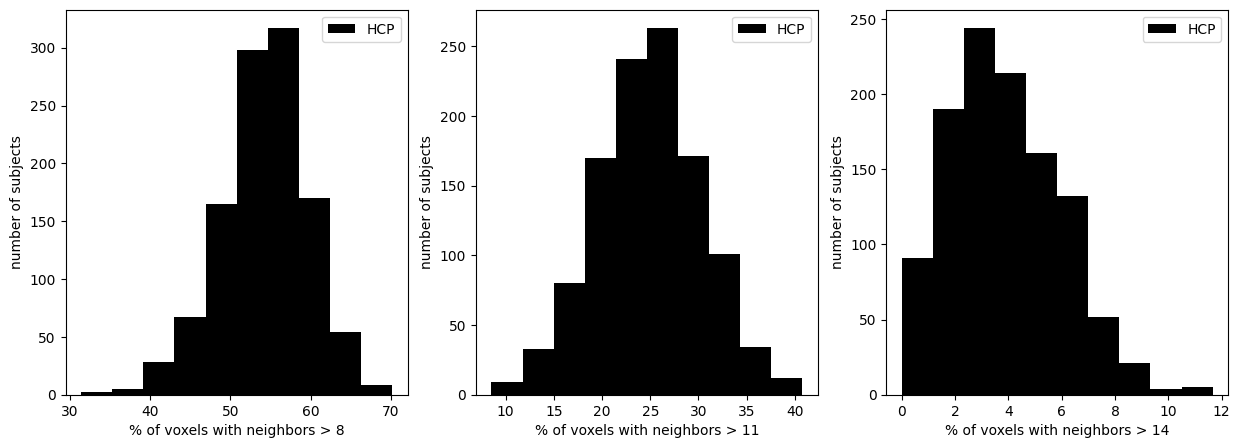

In [13]:
# HCP : is the thickness still there ?

dir_skels = '/neurospin/dico/data/deep_folding/current/datasets/hcp/crops/2mm/CINGULATE_40wks/mask/Rskeleton.npy'
label='HCP'
thresholds = [9, 12, 15]
skels = np.load(dir_skels)
skels = skels[:,:,:,:,0]

list_convolved_skels = get_neighbors(skels, 60)

fig, axs = plt.subplots(ncols=len(thresholds), figsize=(5*len(thresholds), 5))

for idx, threshold in enumerate(thresholds):

    proportion_wrong_thickness = []
    for im in list_convolved_skels:
        proportion_wrong_thickness.append(100 * np.sum(im > threshold) / np.sum(im > 0))

    axs[idx].hist(proportion_wrong_thickness, color='k', label=label)
    axs[idx].set_xlabel(f'% of voxels with neighbors > {threshold-1}')
    axs[idx].set_ylabel('number of subjects')
    axs[idx].legend()
plt.show()

In [43]:
# ACC patterns: create raw skeletons to compare raw to resampled
skel_list_raw=[]
dir_files = '/neurospin/dico/data/deep_folding/current/datasets/ACCpatterns/skeletons/raw/R/'
files = [f for f in os.listdir(dir_files) if f[-1]!='f']
for i, file in enumerate(files):
    nifti = aims.read(dir_files+file)
    skel = nifti.np[:,:,:,0]
    skel_list_raw.append(skel)
    if i > 8:
        break

In [44]:
# ACC patterns: create raw skeletons to compare raw to resampled
skel_list_2mm=[]
dir_files = '/neurospin/dico/data/deep_folding/current/datasets/ACCpatterns/skeletons/2mm/R/'
files = [f for f in os.listdir(dir_files) if f[-1]!='f']
for i, file in enumerate(files):
    nifti = aims.read(dir_files+file)
    skel = nifti.np[:,:,:,0]
    skel_list_2mm.append(skel)
    if i > 8:
        break

In [66]:
hist

array([3.35787163e-04, 2.00611305e-03, 6.26802704e-03, 1.50415429e-02,
       2.91446037e-02, 4.97481596e-02, 6.49705110e-02, 7.92199406e-02,
       9.37362779e-02, 1.10861423e-01, 1.25920186e-01, 1.26815618e-01,
       1.11937664e-01, 7.99173447e-02, 5.07296913e-02, 2.79994834e-02,
       1.46885359e-02, 6.88794180e-03, 2.66907745e-03, 7.83503379e-04,
       2.75517672e-04, 4.30496362e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [70]:
idx

1

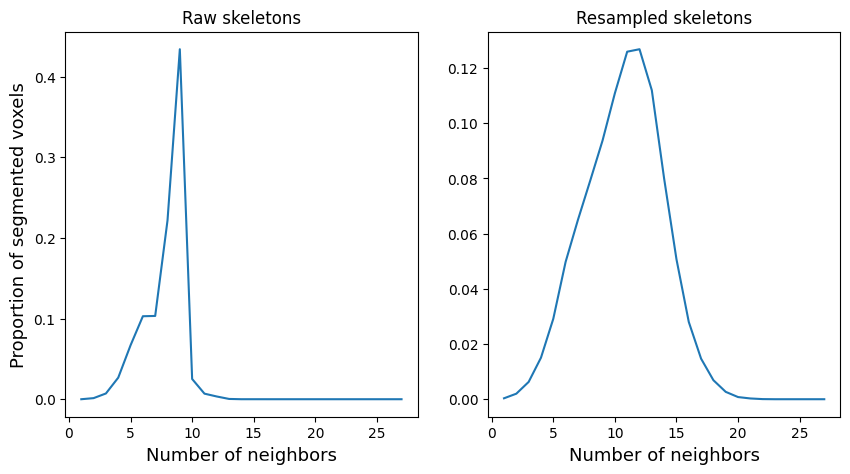

In [75]:
thresholds=range(1, 29)
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

for idx, skels in enumerate([skel_list_raw, skel_list_2mm]):

        list_convolved_skels = get_neighbors(skels, 60)


        hist = np.zeros((len(thresholds[:-1]),))
        for im in list_convolved_skels:
                histo, _ = np.histogram(im, thresholds)
                hist += histo

        hist = hist / np.sum(hist)
        ax = axs[idx]
        ax.plot(thresholds[:-1], hist)
        ax.set_xlabel('Number of neighbors', fontsize=13)
        if idx ==0:
                ax.set_ylabel('Proportion of segmented voxels', fontsize=13)
        if idx==0:
                ax.set_title('Raw skeletons')
        if idx==1:
                ax.set_title('Resampled skeletons')
        plt.savefig('/home/jl274628/Documents/PLOT_RAPPORT/resampling_issue.png')
plt.show()

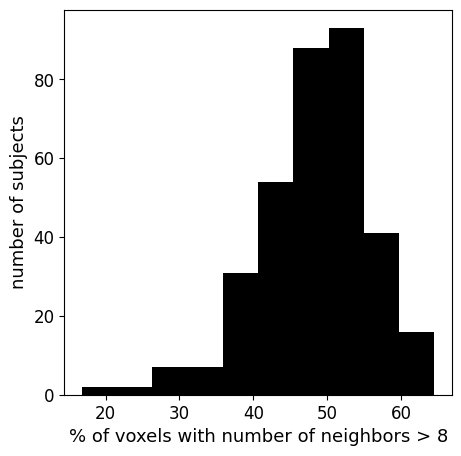

In [46]:
# ACC patterns

dir_skels = '/neurospin/dico/data/deep_folding/current/datasets/ACCpatterns/crops/2mm/CINGULATE_40wks/mask/Rskeleton.npy'
label = 'ACCpatterns'
#thresholds = [9, 12, 15]
thresholds = [9]
skels = np.load(dir_skels)
skels = skels[:,:,:,:,0]

list_convolved_skels = get_neighbors(skels, 60)

fig, axs = plt.subplots(ncols=len(thresholds), figsize=(5*len(thresholds), 5))

for idx, threshold in enumerate(thresholds):

    proportion_wrong_thickness = []
    for im in list_convolved_skels:
        proportion_wrong_thickness.append(100 * np.sum(im > threshold) / np.sum(im > 0))

    if len(thresholds)>1:
        ax=axs[idx]
    else:
        ax=axs
    ax.hist(proportion_wrong_thickness, color='k', label=label)
    ax.set_xlabel(f'% of voxels with number of neighbors > {threshold-1}', fontsize=13)
    ax.set_ylabel('number of subjects', fontsize=13)
    ax.tick_params(axis='both', labelsize=12)
#plt.savefig('/home/jl274628/Documents/PLOT_RAPPORT/resampling_issue.png')
plt.show()

Beware: it isn't true that without resampling the maximum number of neighbors is 8!

In [7]:
# Compare to ACCpatterns Right PCS

dir_skels = '/neurospin/dico/data/deep_folding/current/datasets/ACCpatterns/crops/2mm/CINGULATE_40wks/mask/Rskeleton.npy'

skels = np.load(dir_skels)
skels = skels[:,:,:,:,0]
list_convolved_skels = get_neighbors(skels, 60)

# get Right PCS label
labels = []
labels_df = pd.read_csv('/neurospin/dico/data/deep_folding/papers/miccai2023/Input/csv/ACCpatterns/all.csv', dtype=str, usecols=['long_name', 'Right_PCS'])
subjects = pd.read_csv('/neurospin/dico/data/deep_folding/current/datasets/ACCpatterns/crops/2mm/CINGULATE_40wks/mask/Rskeleton_subject.csv')
subjects = subjects['Subject'].tolist()
for name in subjects:
    df_row = labels_df.loc[labels_df['long_name']==name]
    lab = df_row['Right_PCS'].tolist()[0]
    labels.append(lab!='present')

for threshold in range(9, 18):

    proportion_wrong_thickness = []
    for im in list_convolved_skels:
        proportion_wrong_thickness.append(100 * np.sum(im > threshold) / np.sum(im > 0))

    fpr, tpr, thresholds = metrics.roc_curve(labels, proportion_wrong_thickness, pos_label=1)
    AUC = metrics.auc(fpr, tpr)
    print(f'threshold {threshold}: {AUC}')

threshold 9: 0.5808833897349126
threshold 10: 0.5915820642978004
threshold 11: 0.5985265087422448
threshold 12: 0.6018753525098703
threshold 13: 0.5946489001692048
threshold 14: 0.5853426395939086
threshold 15: 0.5957064297800339
threshold 16: 0.6041137901861252
threshold 17: 0.5862415397631133


Even on ACCpatterns there's a bias for classification of RightPCS!

In [15]:
# create npy files from nifti raw skels
# 100 samples is enough
dir_raw = '/neurospin/dico/data/deep_folding/current/datasets/hcp/skeletons/raw/R/'
files = [f for f in os.listdir(dir_raw) if f[-6:]=='nii.gz']
for idx, file in enumerate(files):
    a = aims.read(dir_raw+file)
    b = a.np
    c = b == 60
    name = file[-13:-7]
    np.save(f'/neurospin/dico/jlaval/data/HCP/raw_skel_{name}.npy',c)
    if idx == 100:
        break

/home/jl274628/Runs/02_deep_supervised/Program/2023_agaudin_jchavas_folding_supervised/venv/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


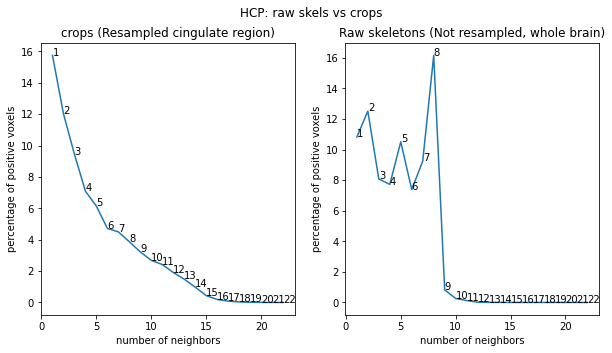

In [11]:
# control : plot the histograms of the number of neighbours in raw skels vs crops
# Use HCP
samples=4
mini=1

plt.close()
fig, axs = plt.subplots(ncols=2, figsize=(10,5))

# crops
dir_skels = '/neurospin/dico/data/deep_folding/current/datasets/hcp/crops/2mm/CINGULATE_40wks/mask/Rskeleton.npy'
skels = np.load(dir_skels)
skels = skels[:,:,:,:,0]
list_convolved_skels = get_neighbors(skels, 60)
convolved_skels = np.array(list_convolved_skels)

hist_neighbors = convolved_skels.flatten()
maxi = np.max(hist_neighbors)
hist = []
for k in range(1, maxi+1):
    nb = np.sum(hist_neighbors == k)
    hist.append(nb)
hist = 100 * np.array(hist) / sum(hist)
truncated_hist = hist[mini:]
x_list = range(mini, maxi)
axs[0].plot(x_list, truncated_hist)
for x,y in zip(x_list, truncated_hist): 
    axs[0].text(x, y, str(x))
axs[0].set_ylabel('percentage of positive voxels')
axs[0].set_xlabel('number of neighbors')
axs[0].set_title('crops (Resampled cingulate region)')

# raw skels
dir_raw = '/neurospin/dico/jlaval/data/HCP/'
files = [f for f in os.listdir(dir_raw)]
raw = []
for idx,file in enumerate(files):
    raw_skel = np.load(dir_raw+file)
    raw_skel = raw_skel[:,:,:,0]
    raw.append(raw_skel)
    if idx >= samples-1:
        break
raw = np.array(raw, dtype=object)
list_convolved_skels = get_neighbors(raw, True) # already simple surfaces only
convolved_skels = np.array(list_convolved_skels)

hist_neighbors_list = []
for im in convolved_skels: # flatten each image here because the dimensions are different
    hist_neighbors_list.append(im.flatten())
hist_neighbors = np.hstack(hist_neighbors_list)
hist = []
for k in range(1, maxi+1):
    nb = np.sum(hist_neighbors == k)
    hist.append(nb)
hist = 100 * np.array(hist) / sum(hist)
truncated_hist = hist[mini:]
x_list = range(mini, maxi)
axs[1].plot(x_list, truncated_hist)
for x,y in zip(x_list, truncated_hist): 
    axs[1].text(x, y, str(x))
axs[1].set_ylabel('percentage of positive voxels')
axs[1].set_xlabel('number of neighbors')
axs[1].set_title('Raw skeletons (Not resampled, whole brain)')

plt.suptitle('HCP: raw skels vs crops')
plt.show()

# import nifti files ? Or convert to numpy before in shell : take simple surfaces too
# plot proportion instead of raw numbers

In [14]:
# test 3D convolution
a = np.array([[[1, 2, 0, 0],
              [5, 3, 0, 4],
              [0, 0, 0, 7],
              [9, 3, 0, 0]],
              [[1, 2, 0, 0],
              [5, 3, 0, 4],
              [0, 0, 0, 7],
              [9, 3, 0, 0]],
              [[1, 2, 0, 0],
              [5, 3, 0, 4],
              [0, 0, 0, 7],
              [9, 3, 0, 0]]])

k = np.array([[[1,1,1],
              [1,1,1],
              [1,1,1]],
              [[1,1,1],
              [1,1,1],
              [1,1,1]],
              [[1,1,1],
              [1,1,1],
              [1,1,1]]])
ndimage.convolve(a, k, mode='constant', cval=0.0)

array([[[22, 22, 18,  8],
        [22, 22, 32, 22],
        [40, 40, 34, 22],
        [24, 24, 20, 14]],

       [[33, 33, 27, 12],
        [33, 33, 48, 33],
        [60, 60, 51, 33],
        [36, 36, 30, 21]],

       [[22, 22, 18,  8],
        [22, 22, 32, 22],
        [40, 40, 34, 22],
        [24, 24, 20, 14]]])

In [18]:
# understanding zoom function

input = np.random.rand(10,10)
output_shape=(30,30)
zoom_div = np.array(output_shape, float) - 1
zoom_ = np.divide(np.array(input.shape) - 1, zoom_div,
                    out=np.ones_like(input.shape, dtype=np.float64),
                    where=zoom_div != 0)

In [20]:
print(zoom_)
print(9/29)

[0.31034483 0.31034483]
0.3103448275862069
